In [ ]:
# Install Java, Spark, and Findspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [6]:
# I have yelp 100k dataset loaded into my google drive
# this allows me to access that data from inside spark
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [7]:
# Start a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word2vec").getOrCreate()

In [8]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import Word2Vec
import string

schema = StructType([StructField("text", StringType(), True)])

In [9]:
# This URL is on my gdrive only! I loaded it there from a download from the internet
url = "/content/gdrive/MyDrive/covidvaccinedata_2021-03-13_v2_AGP_All-NEG.csv"
df = spark.read.schema(schema).csv(url, sep=",", header=False)

In [10]:
df.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                           |
+-------------------------------------------------------------------------------------------------------------------------------+
|TEXT_CLEANED                                                                                                                   |
| Well lets qualify that would anyone of any party get a vaccine rushed out  minimally tested coming from Russia CovidVaccine   |
|Is more dangerous yet  come                                                                                                    |
|CovidVaccine Corona Immunization CoronavirusPemic mutation D614GVirus                                                          |
|D614 "                                                                                   

In [11]:
# punctuation removal due to relatively small datasize
def remove_punctuation(txt):
  return "".join(l if l not in string.punctuation else "" for l in txt)

In [12]:
from pyspark.sql.functions import col, udf

remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_punctuation_udf

<function __main__.remove_punctuation>

In [13]:
df = df.withColumn("clean_text", remove_punctuation_udf(col("text")))
df.show()

+--------------------+--------------------+
|                text|          clean_text|
+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|
| Well lets qualif...| Well lets qualif...|
|Is more dangerous...|Is more dangerous...|
|CovidVaccine Coro...|CovidVaccine Coro...|
|              D614 "|               D614 |
|phase 3 trials be...|phase 3 trials be...|
|A single vaccinat...|A single vaccinat...|
|You must tell you...|You must tell you...|
| your gonna go do...| your gonna go do...|
|CovidVaccine Scar...|CovidVaccine Scar...|
|Russia  China has...|Russia  China has...|
|The National Spor...|The National Spor...|
|             COVID19|             COVID19|
|      CovidVaccine "|       CovidVaccine |
|Just received my ...|Just received my ...|
|Now waiting for a...|Now waiting for a...|
|GERN up 7 day Its...|GERN up 7 day Its...|
|Bought 500 shares...|Bought 500 shares...|
| You pay me 5000 ...| You pay me 5000 ...|
|Covid19 vaccine t...|Covid19 va

In [14]:
# pandas dataframe to measure length
df_new = df.toPandas()
len(df_new)

28350

In [15]:
from pyspark.sql.functions import length
length(df.text)

Column<b'length(text)'>

In [16]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# "Creating pipeline..."
tokenizer = Tokenizer(inputCol="clean_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text', outputCol='features')

pipeline = Pipeline(stages=[tokenizer, stopremove])

# "Training model..."
pipeline_stg = pipeline.fit(df)
final_df = pipeline_stg.transform(df)
final_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|
+--------------------+--------------------+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|       [textcleaned]|       [textcleaned]|
| Well lets qualif...| Well lets qualif...|[, well, lets, qu...|[, well, lets, qu...|
|Is more dangerous...|Is more dangerous...|[is, more, danger...|[dangerous, yet, ...|
|CovidVaccine Coro...|CovidVaccine Coro...|[covidvaccine, co...|[covidvaccine, co...|
|              D614 "|               D614 |              [d614]|              [d614]|
|phase 3 trials be...|phase 3 trials be...|[phase, 3, trials...|[phase, 3, trials...|
|A single vaccinat...|A single vaccinat...|[a, single, vacci...|[single, vaccinat...|
|You must tell you...|You must tell you...|[you, must, tell,...|[must, tell, matt...|
| your gonna go do...| your gonna go do...|[, your, go

In [17]:
# in class I had used vectorsize of 200 and max iterations of 2
word2vec = Word2Vec(
    vectorSize=200,
    seed=42,
    inputCol="features",
    outputCol="model"
).setMaxIter(3)
model = word2vec.fit(final_df)

In [18]:
model.getVectors().show(truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
vecs = model.getVectors()

In [20]:
vecs.filter(vecs["word"] == "incident").show()

+--------+--------------------+
|    word|              vector|
+--------+--------------------+
|incident|[0.02293781749904...|
+--------+--------------------+



In [21]:
# TEST WORDS HERE
model.findSynonymsArray("shot", 20)

[('jab', 0.821910560131073),
 ('dose', 0.8063942193984985),
 ('got', 0.748012900352478),
 ('booster', 0.7450438141822815),
 ('moderna', 0.7350273132324219),
 ('hopefully', 0.7346007823944092),
 ('books', 0.7333641648292542),
 ('round', 0.7274484634399414),
 ('hubby', 0.7217872738838196),
 ('apart', 0.7161676287651062),
 ('finally', 0.7155572772026062),
 ('dos', 0.7152366638183594),
 ('mine', 0.696872353553772),
 ('today', 0.6943196654319763),
 ('wave', 0.688512921333313),
 ('malaise', 0.6781587600708008),
 ('pfizervaccine', 0.6771197319030762),
 ('mins', 0.6733497977256775),
 ('bed', 0.6729925870895386),
 ('24hrs', 0.6727504730224609)]

In [22]:
w2v = model.transform(final_df)

In [23]:
w2v.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|               model|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|       [textcleaned]|       [textcleaned]|[0.0,0.0,0.0,0.0,...|
| Well lets qualif...| Well lets qualif...|[, well, lets, qu...|[, well, lets, qu...|[0.01059647876148...|
|Is more dangerous...|Is more dangerous...|[is, more, danger...|[dangerous, yet, ...|[0.05217896588146...|
|CovidVaccine Coro...|CovidVaccine Coro...|[covidvaccine, co...|[covidvaccine, co...|[0.04713531335194...|
|              D614 "|               D614 |              [d614]|              [d614]|[0.0,0.0,0.0,0.0,...|
|phase 3 trials be...|phase 3 trials be...|[phase, 3, trials...|[phase, 3, trials...|[0.02850305525442...|
|A single vaccinat...|A single vaccin

In [24]:
w2v_clustering = w2v.select(
    "text", "model"
).withColumnRenamed("model", "features")

In [25]:
w2v_clustering.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
PCAmodel = pca.fit(w2v_clustering)
result = PCAmodel.transform(w2v_clustering)
result.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
result = result.select("text", "pcaFeatures")
w2v_clustering = result.withColumnRenamed("pcaFeatures", "features")
w2v_clustering.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                           |features                                                                                                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model. < TRY NEW GROUP NUMBERS HERE 
kmeans = KMeans().setK(7).setSeed(1)
km_model = kmeans.fit(w2v_clustering)

In [33]:
# Make predictions
predictions = km_model.transform(w2v_clustering)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

# TEST YOUR FIT
# silhouette score goes between -1, 1. 1 is better. Negative is bad
silhouette = evaluator.evaluate(predictions)
print("Silhouette with cosine distance = " + str(silhouette))

Silhouette with cosine distance = 0.24835517414246547


In [30]:
# AGP INSERT >> FIND BEST CLUSTER Size? ["Elbow Method"]
import numpy as np
import pandas as pd

# Calculate clusterSize and plot
clusterSize = np.zeros(21)

for k in range(2,20):
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(1)
    km_model = kmeans.fit(w2v_clustering)
    predictions = km_model.transform(w2v_clustering)
    evaluator = ClusteringEvaluator(distanceMeasure="cosine")
    clusterSize[k] = evaluator.evaluate(predictions)

# Define the dataframe of cosines
df_clusterSize = pd.DataFrame(clusterSize[2:])
df_clusterSize.columns = ["cosine"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
df_clusterSize.insert(0, 'cluster', new_col)

df_clusterSize

,cluster,cosine
0,2,0.000000
1,3,0.000000
2,4,0.000000
3,5,0.102980
4,6,0.239801
5,7,0.248355
6,8,0.246070
7,9,0.107538
8,10,0.144963
9,11,0.157894


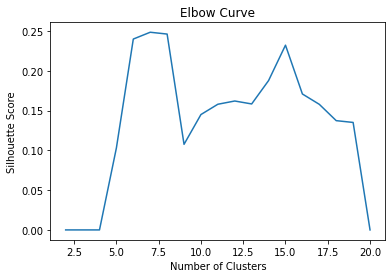

In [31]:
# PLOT the cosines

import pylab as pl
pl.plot(df_clusterSize.cluster, df_clusterSize.cosine)
pl.xlabel('Number of Clusters')
pl.ylabel('Silhouette Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
predictions.show()

+--------------------+--------------------+----------+
|                text|            features|prediction|
+--------------------+--------------------+----------+
|        TEXT_CLEANED|[0.0,0.0,0.0,0.0,...|         7|
|Al Gore Didnt he ...|[-0.0599538410468...|         8|
|ClimateChange aka...|[0.0,0.0,0.0,0.0,...|         7|
|Belgian newspaper...|[0.05067667245965...|         8|
|Covid Vaccine Tri...|[0.25735706780703...|         2|
|covid vaccine imm...|[0.39020194973401...|         3|
|Covid19 vaccine c...|[0.24317832544220...|         4|
|Presented by Dr A...|[6.53984630036426...|         7|
|56 are in Phase I...|[0.04490243430432...|         8|
|A list of who sho...|[-0.0495259951342...|         0|
|Im talking  some ...|[-0.0776420937737...|         0|
|You know what I d...|[-0.0608359925809...|         0|
| Yes  key thread was|[-0.1448855019964...|         0|
|1 should GPs deli...|[0.12755208585296...|         8|
|2 how can this be...|[-5.6977906877236...|         8|
|         

In [ ]:
predictions.filter("prediction=6").show(50, truncate=False)

+---------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                               |features                                                                                                                                                                                                           |prediction|
+---------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|AstraZeneca CovidVaccine QuickTake                 |[-0.5042872232435108,-0.4244550587161168,-0.09282570179091675,0.09685284144724195,0.04865785002721759,7.357510826703